## Computer Personalized Source Functions from OGTT

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns;
%matplotlib inline

In [12]:
import sys

sys.path.insert(0, "/home/mehrdad/Dropbox/utils/Ackerman/")

import PersonalizeParams as pp

## Load AVG 50 OGTT data and model

max glucose 3.666666666666666


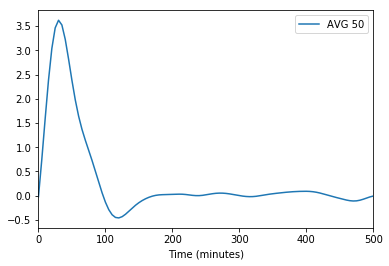

In [14]:
avg_50 = pp.avg_source_function("/home/mehrdad/Dropbox/work/gi-sensitivity-analysis/data/response-curve-data/cleaned/glucose-50g.csv")

time_samples = np.arange(0,2000,5)

plt.plot(time_samples, avg_50.signal(time_samples), label = "AVG 50")
plt.xlim([0,500])
plt.xlabel("Time (minutes)")
plt.legend();

## Load subject OGTT data

In [17]:
ogtt_and_more = pd.read_csv("/data/glucolytes/journal.pbio.2005143.s017.tsv", sep = "\t")
ogtt_df = ogtt_and_more[ogtt_and_more.parameter == "OGTT"]


In [18]:
ogtt_df_subject = ogtt_df[ogtt_df.userID == "1636-69-001"]
ogtt_df_subject

userID        date  timepoint_mins  value parameter
31  1636-69-001  2013-11-11             0.0  147.0      OGTT
32  1636-69-001  2013-11-11            30.0  197.0      OGTT
33  1636-69-001  2013-11-11           120.0  205.0      OGTT

In [20]:
snyder_subject_model = pp.ModelGP()

X = ogtt_df_subject.value
X.index = ogtt_df_subject.timepoint_mins

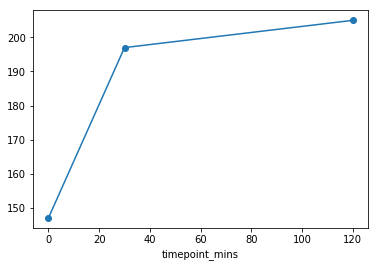

In [25]:
X.plot(marker = 'o')

In [29]:
df_meals = pd.read_csv("/data/glucolytes/S6_Data.tsv", sep = "\t")

df_meals.time = pd.to_datetime(df_meals.time)
df_meals.GlucoseValue = pd.to_numeric(df_meals.GlucoseValue, errors="coerce")

df_meals.shape

(6152, 4)

In [30]:
len(pd.unique(df_meals.userID))

30

In [28]:
len(pd.unique(ogtt_df.userID))

64

In [36]:
## subjects that have both OGTT and meals
subjects_meals_ogtt = set(df_meals.userID) & set(ogtt_df.userID)
len(subjects_meals_ogtt)

28

## Viz OGTT's of subjects

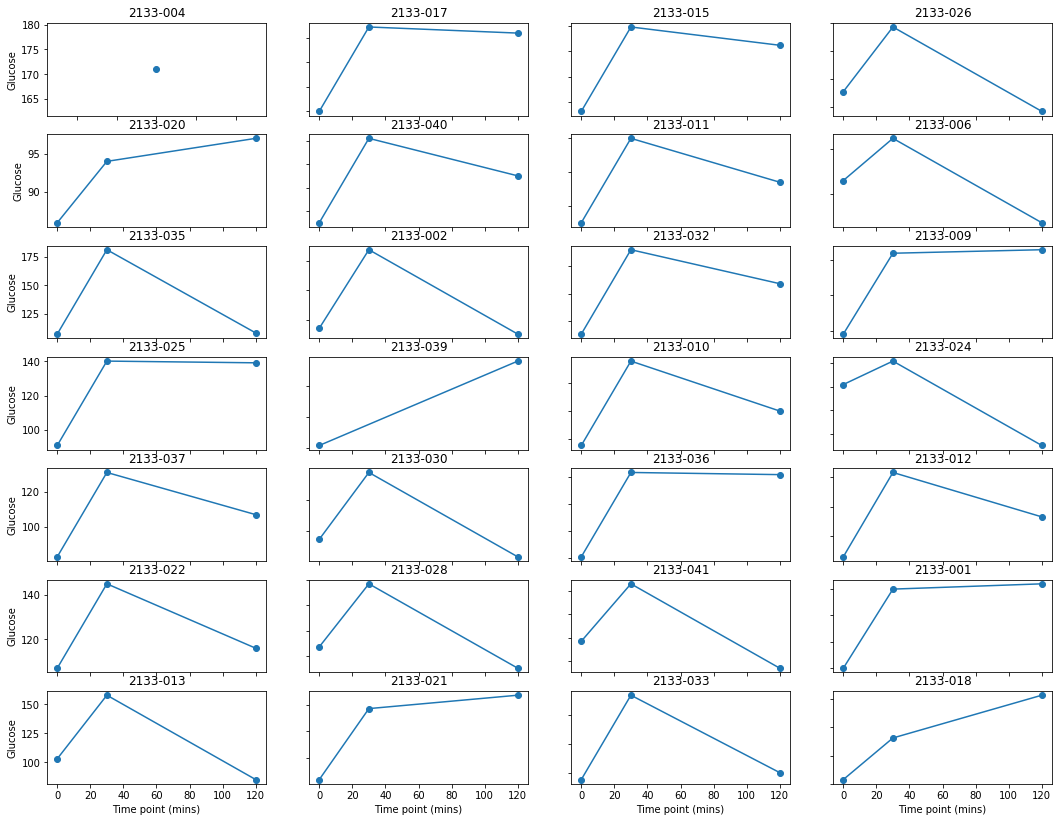

In [45]:
plt.figure(figsize=(18,14))

for i, highlighted_subject in enumerate(subjects_meals_ogtt):
    plt.subplot(7,4,i+1)
    ogtt_df_subject = ogtt_df[ogtt_df.userID == highlighted_subject]
    
    plt.plot(ogtt_df_subject.timepoint_mins, ogtt_df_subject.value, "-o")
    plt.title(highlighted_subject)
    if i%4 == 0:
        plt.ylabel("Glucose")
        
    else:
        plt.tick_params(labelleft=False) 
    
    if i < (28-4):
        plt.tick_params(labelbottom=False)
    else:
        plt.xlabel("Time point (mins)")
    

## Compare OGTT's of subjects against Miller AVG

In [51]:
import sqlite3
conn = sqlite3.connect("/data/glucolytes/S5_data.db")


df_meta = pd.read_sql_query("SELECT * from clinical", conn)



df_meta.head()

userID   Age   BMI  A1C    FBG  ogtt.2hr  insulin  hs.CRP  Tchol  \
0  1636-69-001  59.0  21.7  6.7  109.0     205.0      9.0     0.3  204.0   
1  1636-69-026  67.0  28.9  6.2   97.0     152.0      7.0     1.2  208.0   
2  1636-69-028  50.0  27.3  5.2   91.0     121.0      4.0     4.4  127.0   
3  1636-69-032  59.0  25.0  5.7   82.0     142.0      5.0     0.2  224.0   
4  1636-69-035  60.0  28.2  5.5   87.0     118.0      NaN     0.2  224.0   

     Trg  ...   freq_low  freq_moderate  freq_severe  glucotype  Height  \
0  135.0  ...   0.147059       0.369748     0.483193     severe   176.3   
1   76.0  ...   0.004202       0.289916     0.705882     severe   157.5   
2   25.0  ...   0.008403       0.424370     0.567227     severe     NaN   
3  138.0  ...   0.021008       0.491597     0.487395   moderate   169.4   
4   85.0  ...   0.029412       0.352941     0.617647     severe   176.5   

   Weight  Insulin_rate_dd  perc_cgm_prediabetic_range  \
0    68.0          0.10150                    0.190404   
1    76.0              NaN                   0.0831202   
2     NaN              NaN                   0.0714286   
3    68.2          0.01575                   0.0147643   
4    82.5          0.05642                     0.15465   

   perc_cgm_diabetic_range  SSPG  
0                0.0262106    91  
1                        0   133  
2                0.0015444    75  
3                        0    87  
4               0.00592128   160  

[5 rows x 49 columns]

In [60]:
df_meta.diagnosis.value_counts()

non-diabetic    38
pre-diabetic    14
diabetic         5
Name: diagnosis, dtype: int64

In [71]:
df_meta.groupby(["diagnosis"])["A1C"].describe()

count      mean       std  min  25%   50%    75%  max
diagnosis                                                          
diabetic        5.0  6.140000  0.634823  5.1  6.0  6.40  6.500  6.7
non-diabetic   36.0  5.208333  0.204765  4.6  5.1  5.20  5.325  5.6
pre-diabetic   14.0  5.678571  0.311766  5.2  5.5  5.65  5.875  6.2

In [55]:
healthy_subjects = df_meta[df_meta.diagnosis == 'non-diabetic']

In [59]:
healthy_subjects_ids = set(df_meals.userID) & set(ogtt_df.userID)  & set(healthy_subjects.userID)
len(healthy_subjects_ids)

19

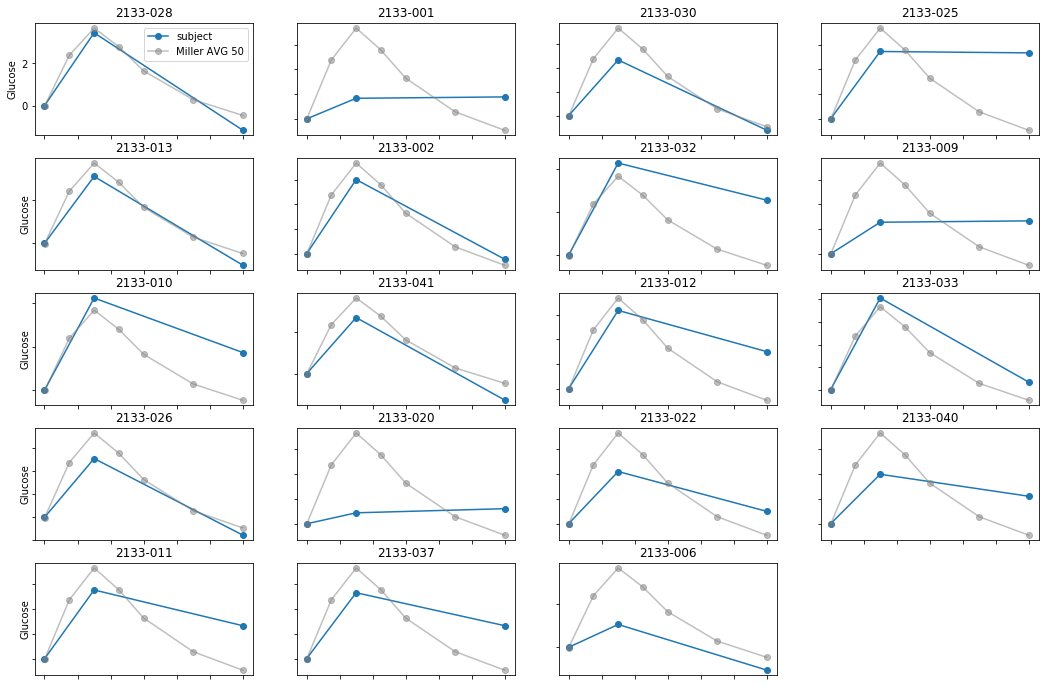

In [70]:
plt.figure(figsize=(18,12))

for i, highlighted_subject in enumerate(healthy_subjects_ids ):
    plt.subplot(5,4,i+1)
    ogtt_df_subject = ogtt_df[ogtt_df.userID == highlighted_subject]
    
    plt.plot(ogtt_df_subject.timepoint_mins, (ogtt_df_subject.value.values - ogtt_df_subject.value.values[0])/18 , "-o", 
             label = "subject")
    plt.plot(avg_ogtt.time, avg_ogtt.glucose, "-o", color = "gray", alpha = .5, label = "Miller AVG 50")
    plt.title(highlighted_subject)
    if i%4 == 0:
        plt.ylabel("Glucose")
    if i == 0:
        plt.legend()        
    else:
        plt.tick_params(labelleft=False) 
    
    if i < (28-4):
        plt.tick_params(labelbottom=False)
    else:
        plt.xlabel("Time point (mins)")
    

In [50]:
ogtt_and_more

userID        date  timepoint_mins    value     parameter
0     1636-69-001  2013-11-11             0.0   900.60  Calculated_C
1     1636-69-001  2013-11-11            15.0  1091.20  Calculated_C
2     1636-69-001  2013-11-11            30.0  1349.10  Calculated_C
3     1636-69-001  2013-11-11            45.0  1649.70  Calculated_C
4     1636-69-001  2013-11-11            60.0  1981.70  Calculated_C
5     1636-69-001  2013-11-11            75.0  2337.30  Calculated_C
6     1636-69-001  2013-11-11            90.0  2710.70  Calculated_C
7     1636-69-001  2013-11-11           105.0  3097.40  Calculated_C
8     1636-69-001  2013-11-11           120.0  3494.40  Calculated_C
9     1636-69-001  2013-11-11           120.0   109.00           FBG
10    1636-69-001  2013-11-11             0.0     3.18  Insulin_Rate
11    1636-69-001  2013-11-11            15.0     4.71  Insulin_Rate
12    1636-69-001  2013-11-11            30.0     6.24  Insulin_Rate
13    1636-69-001  2013-11-11            45.0     7.77  Insulin_Rate
14    1636-69-001  2013-11-11            60.0     9.29  Insulin_Rate
15    1636-69-001  2013-11-11            75.0    10.81  Insulin_Rate
16    1636-69-001  2013-11-11            90.0    12.33  Insulin_Rate
17    1636-69-001  2013-11-11           105.0    13.84  Insulin_Rate
18    1636-69-001  2013-11-11           120.0    15.36  Insulin_Rate
19    1636-69-001  2013-11-11             0.0    12.60  Insulin_uuml
20    1636-69-001  2013-11-11            30.0    22.10  Insulin_uuml
21    1636-69-001  2013-11-11           120.0    64.40  Insulin_uuml
22    1636-69-001  2013-11-11             0.0   900.60    Measured_C
23    1636-69-001  2013-11-11            15.0      NaN    Measured_C
24    1636-69-001  2013-11-11            30.0  1443.60    Measured_C
25    1636-69-001  2013-11-11            45.0      NaN    Measured_C
26    1636-69-001  2013-11-11            60.0      NaN    Measured_C
27    1636-69-001  2013-11-11            75.0      NaN    Measured_C
28    1636-69-001  2013-11-11            90.0      NaN    Measured_C
29    1636-69-001  2013-11-11           105.0      NaN    Measured_C
...           ...         ...             ...      ...           ...
2338     2133-040  2017-07-06           120.0     4.00       insulin
2339     2133-041  2017-07-21           120.0    93.00           FBG
2340     2133-041  2017-07-21             0.0    97.00          OGTT
2341     2133-041  2017-07-21            30.0   146.00          OGTT
2342     2133-041  2017-07-21           120.0    74.00          OGTT
2343     2133-041  2017-07-21           120.0    58.00          SSPG
2344     2133-041  2017-07-21           120.0     3.00       insulin
2345     2133-042  2017-05-05           120.0    67.00          SSPG
2346     2133-042  2017-07-26           120.0    89.00           FBG
2347     2133-042  2017-07-26             0.0    93.00          OGTT
2348     2133-042  2017-07-26            30.0   161.00          OGTT
2349     2133-042  2017-07-26           120.0   148.00          OGTT
2350     2133-042  2017-07-26           120.0     6.00       insulin
2351     2133-043  2017-07-07           120.0    50.00          SSPG
2352     2133-043  2017-08-10           120.0    76.00           FBG
2353     2133-043  2017-08-10             0.0    87.00          OGTT
2354     2133-043  2017-08-10            30.0   180.00          OGTT
2355     2133-043  2017-08-10           120.0   122.00          OGTT
2356     2133-043  2017-08-10           120.0     4.00       insulin
2357     2133-044  2017-07-28           120.0    97.00           FBG
2358     2133-044  2017-07-28             0.0   101.00          OGTT
2359     2133-044  2017-07-28            30.0   132.00          OGTT
2360     2133-044  2017-07-28           120.0   109.00          OGTT
2361     2133-044  2017-07-28           120.0     5.00       insulin
2362     2133-044  2017-08-23           120.0      NaN          SSPG
2363     2133-045         NaN           120.0      NaN          SSPG
2364     

In [64]:
# The OG OGTT:

avg_ogtt = pd.read_csv("/home/mehrdad/Dropbox/work/gi-sensitivity-analysis/data/response-curve-data/cleaned/glucose-50g.csv", header = None)
avg_ogtt.columns = ["time", "glucose"]

In [63]:
avg_ogtt.head()

0         1
0   0.103448 -0.007937
1  15.000000  2.380952
2  30.034483  3.666667
3  44.931034  2.785714
4  59.965517  1.642857

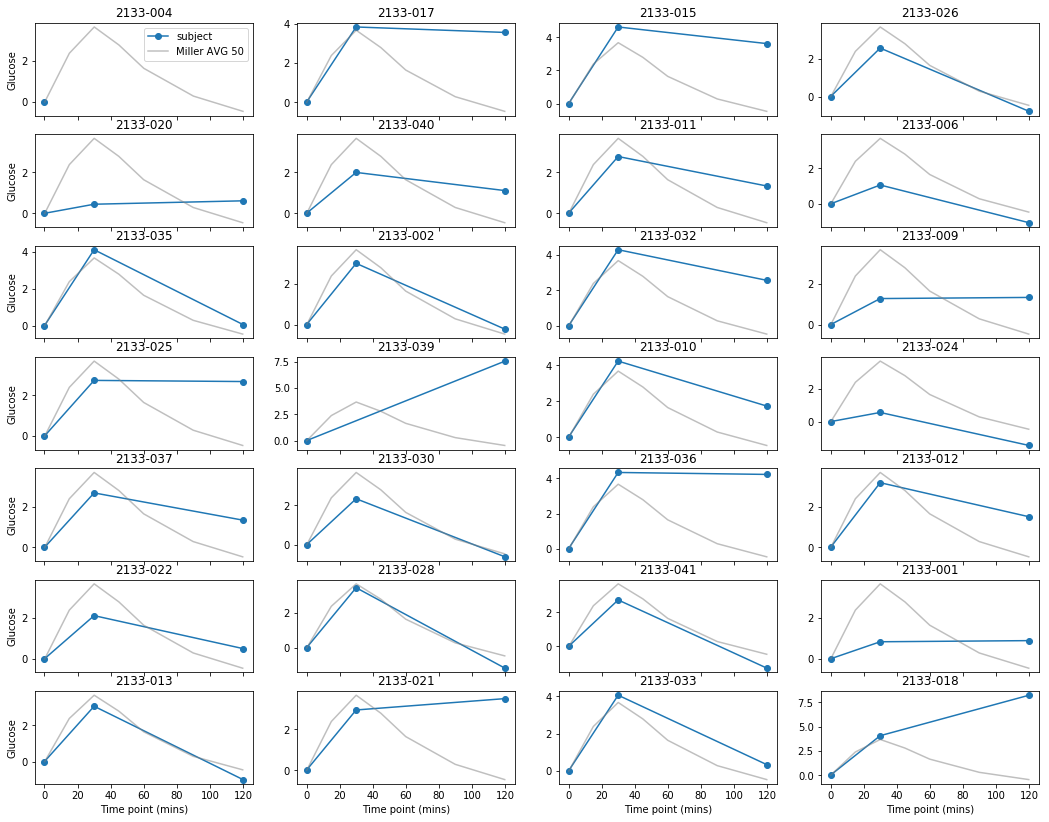

In [66]:
plt.figure(figsize=(18,14))

for i, highlighted_subject in enumerate(subjects_meals_ogtt):
    plt.subplot(7,4,i+1)
    ogtt_df_subject = ogtt_df[ogtt_df.userID == highlighted_subject]
    
    plt.plot(ogtt_df_subject.timepoint_mins, (ogtt_df_subject.value.values - ogtt_df_subject.value.values[0])/18 , 
             "-o", label = "subject")
    plt.plot(avg_ogtt.time, avg_ogtt.glucose, color = "gray",alpha = .5, label = "Miller AVG 50")
    plt.title(highlighted_subject)
    if i%4 == 0:
        plt.ylabel("Glucose")
        
    if i == 0:
        plt.legend()
    
    if i < (28-4):
        plt.tick_params(labelbottom=False)
    else:
        plt.xlabel("Time point (mins)")

In [ ]:
snyder_subject_model.fit_gp(X)